Sentiment counts before balancing:
 sentiment
positive    158
neutral      63
negative     29
Name: count, dtype: int64
Sentiment counts after balancing:
 sentiment
neutral     158
positive    158
negative    158
Name: count, dtype: int64
🚀 Training model...
✅ Test Accuracy: 93.68%
              precision    recall  f1-score   support

    negative       0.94      1.00      0.97        31
     neutral       0.88      0.94      0.91        32
    positive       1.00      0.88      0.93        32

    accuracy                           0.94        95
   macro avg       0.94      0.94      0.94        95
weighted avg       0.94      0.94      0.94        95



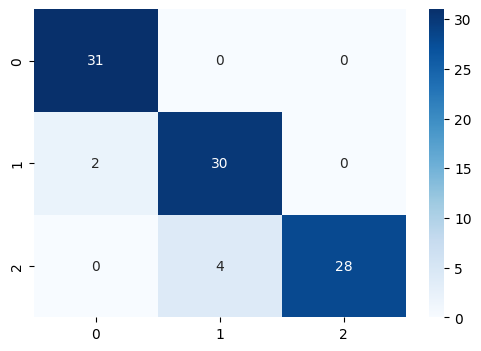

💾 Saved pipeline: sentiment_pipeline_75plus_nb_balanced.joblib
Text: This product is awesome, I love it!
Predicted: positive

Text: It was okay, nothing special.
Predicted: positive

Text: Terrible quality, waste of money.
Predicted: neutral



In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# ---------- NLTK setup ----------
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("vader_lexicon", quiet=True)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# ---------- Load dataset ----------
df = pd.read_csv("SentimentDataset.csv")
text_col = "review"

# Drop very short reviews
df = df[df[text_col].str.split().str.len() > 2].reset_index(drop=True)

# ---------- VADER sentiment labeling ----------
sia = SentimentIntensityAnalyzer()

def label_with_vader(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.3:
        return "positive"
    elif score <= -0.3:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df[text_col].apply(label_with_vader)
print("Sentiment counts before balancing:\n", df['sentiment'].value_counts())

# ---------- Upsample minority classes ----------
df_positive = df[df.sentiment=="positive"]
df_negative = df[df.sentiment=="negative"]
df_neutral  = df[df.sentiment=="neutral"]

max_size = max(len(df_positive), len(df_negative), len(df_neutral))

df_positive_up = df_positive.sample(max_size, replace=True, random_state=42)
df_negative_up = df_negative.sample(max_size, replace=True, random_state=42)
df_neutral_up  = df_neutral.sample(max_size, replace=True, random_state=42)

df_balanced = pd.concat([df_positive_up, df_negative_up, df_neutral_up]).sample(frac=1, random_state=42)
print("Sentiment counts after balancing:\n", df_balanced['sentiment'].value_counts())

# ---------- Custom Text Preprocessor ----------
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english")) - {"not", "no"}  # preserve negations

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self._clean_text(text) for text in X]

    def _clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r"[^a-z\s!?]", "", text)  # preserve ! and ? for sentiment
        tokens = nltk.word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(w) for w in tokens if w not in self.stop_words]
        return " ".join(tokens)

# ---------- Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced[text_col],
    df_balanced['sentiment'],
    test_size=0.2,
    stratify=df_balanced['sentiment'],
    random_state=42
)

# ---------- Build pipeline ----------
model_pipeline = Pipeline([
    ("preprocess", TextPreprocessor()),
    ("tfidf", TfidfVectorizer(max_features=None, ngram_range=(1,2), min_df=1, max_df=1.0)),
    ("nb", MultinomialNB())
])

# ---------- Train ----------
print("🚀 Training model...")
model_pipeline.fit(X_train, y_train)

# ---------- Evaluate ----------
y_pred = model_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.show()

# ---------- Save pipeline ----------
joblib.dump(model_pipeline, "sentiment_pipeline_75plus_nb_balanced.joblib")
print("💾 Saved pipeline: sentiment_pipeline_75plus_nb_balanced.joblib")

# ---------- Test sample predictions ----------
samples = [
    "This product is awesome, I love it!",
    "It was okay, nothing special.",
    "Terrible quality, waste of money."
]

for s in samples:
    print(f"Text: {s}")
    print(f"Predicted: {model_pipeline.predict([s])[0]}\n")
